Here is an example for solving a regreesion problem.

In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

The dataset contains 404 examples of training and 102 examples for testing. Each example is a list of 13 floating point variables. As these variable have different ranges of value the model could struggle to create an accurate inferance. This can be corrected by noralising the data.

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# never user values computed on the test data
test_data -= mean
test_data /= std

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


Because of small number of training examples it would not be productive to seperate out a portion for validation. Instead the K-fold method is used.

In [8]:
%%time

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_trian_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model() 
    history = model.fit(
        partial_trian_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        batch_size=1,
        epochs=num_epochs,
        verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
CPU times: user 24min 13s, sys: 13min 41s, total: 37min 54s
Wall time: 17min 59s


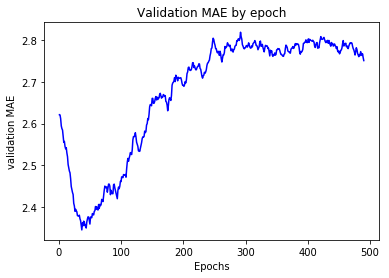

In [15]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_average = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_average) + 1), smooth_mae_average, 'b')
plt.title('Validation MAE by epoch')
plt.xlabel('Epochs')
plt.ylabel('validation MAE')
plt.show()

In [28]:
model = build_model()
model.fit(
    train_data,
    train_targets,
    batch_size=8,
    epochs=80,
    verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 1ms/sample - loss: 15.3892 - mean_absolute_error: 2.4023


2.4022696